# Fisher forecast for Euclid 3x2-point constraint on LCDM and beyond-LCDM parameters

In this notebook we use [```jax-cosmo```](https://github.com/DifferentiableUniverseInitiative/jax_cosmo) to perform a Fisher forecast for the constraint on standard andd non-standard cosmological parameters from Euclid data. The cosmological parameters include:

$[\Omega_m,\Omega_b,h,n_s,S_8,w_0,w_a,\gamma_0,\gamma_1]$

where $[\Omega_m,\Omega_b,h,n_s,S_8]$ are the standard, i.e. $\Lambda$CDM parameters,

while $[w_0,w_a]$ are the DE equation of state parameters, $w(a)=w_0+w_a(1-a)=w_0+w_a\frac{z}{1+z}$ [[1]](https://arxiv.org/abs/astro-ph/0208512),

and $[\gamma_0,\gamma_1]$ are the growth-index parameters, $\gamma(z)=\gamma_0+\gamma_1\frac{z^2}{1+z}$ [[2]](https://arxiv.org/abs/2304.07281).

This is part of the project documented in [[3]](https://www.overleaf.com/read/tmggbrcfsncd) on Overleaf.

## Load the python modules

In [1]:
## os library for computer path
import os.path

## numpy library
import numpy as np

## jax library for autodiff
import jax
## enable x64
jax.config.update("jax_enable_x64", True)
import jax.numpy as np
## jax-cosmo library - main driver for producing observables and fisher forecasts
import jax_cosmo as jc
## CCL library - DES official library, serves a cross-check of the Fisher matrix stability in jax-cosmo
import pyccl as ccl

## astropy module to handle fits file
from astropy.io import fits

## matplotlib library
import matplotlib
from matplotlib.ticker import MultipleLocator, FormatStrFormatter # for tick format
from matplotlib import cm # for colormaps
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
## personal preference for matplotlib fonts
plt.rcParams.update({
    #"text.usetex": True,
    #"font.family": "sans-serif",
    #"font.sans-serif": "Computer Modern",
    "font.size": 22})

## Generate the redshift distributions

### Generate source and lens n(z)

We follow Frusciante, et. al. ([arXiv:2306.12368](https://arxiv.org/abs/2306.12368)) in using a Smail redshift distribution for galaxies
$$n(z)\propto z^2\mathrm{exp}[-(z/z_0)^\alpha],$$
divided into 10 tomographic bins. For both the lens and source galaxies, we take $(\alpha,z_0) = (3/2, 0.9/\sqrt{2})$ and $n_\mathrm{eff} = 30\text{ arcmin}^{-2}.$ We then divide each distribution into 10 tomographic bins.

In [2]:
#Source and lens n(z) are identical for now.
n_source_eff = 30
nz_s = jc.redshift.smail_nz(2, 1.5, .9*2**-.5, gals_per_arcmin2 = 30, zmax=2.5)
#nz_s = jc.redshift.smail_nz(2,2,2, n_gals_per_armin2=n_source_eff)
n_lens_eff = 30
#nz_l = jc.redshift.smail_nz(2, .94, .26, gals_per_arcmin2=n_lens_eff)
#nz_l = jc.redshift.smail_nz(2,2,2, n_gals_per_armin2=n_lens_eff)
zbin_edges_s = np.array([.001, .42, .56, .68, .79, .9, 1.02, 1.15, 1.32, 1.58, 2.5])

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
zbin_centers_s=0.5*(zbin_edges_s[:-1] + zbin_edges_s[1:])
zbin_widths_s=zbin_edges_s[1:]-zbin_edges_s[:-1]
zbin_transitions_s=np.ones_like(zbin_centers_s)*0.05
zbin_smooth_sigmas_s=np.ones_like(zbin_centers_s)*0.05
print(zbin_centers_s)
print(zbin_widths_s)

[0.2105 0.49   0.62   0.735  0.845  0.96   1.085  1.235  1.45   2.04  ]
[0.419 0.14  0.12  0.11  0.11  0.12  0.13  0.17  0.26  0.92 ]


In [4]:
nzs_s = [jc.redshift.gaussian_sigmoid_nz(nz_s,
                        zbin_centers_s[i], zbin_widths_s[i], zbin_transitions_s[i],
                        0.0, bw=zbin_smooth_sigmas_s[i], gals_per_arcmin2=nz_s(zbin_centers_s[i]))
                        # bw=zbin_smooth_sigmas[i])
        for i in range(zbin_centers_s.shape[0])]

zbin_centers_l = zbin_centers_s
nzs_l = nzs_s

In [5]:
for i in nzs_s:
    print(i.gals_per_arcmin2)

0.21398525607104624
0.713626337369088
0.8583433571251557
0.9120693663240794
0.903100805487223
0.8441170053864896
0.7422568548101199
0.5967085816720146
0.39409057413510756
0.07820587332168977


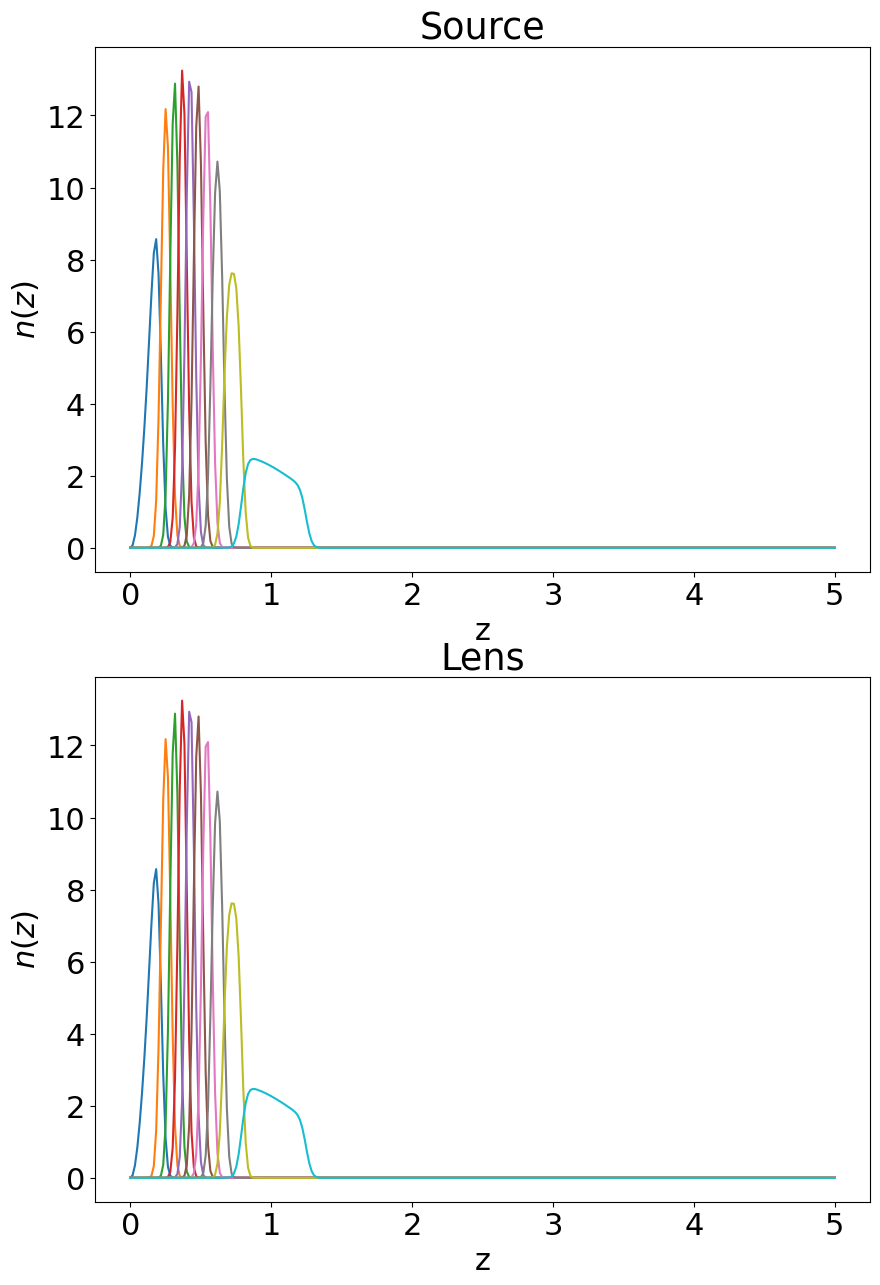

In [6]:
z = np.linspace(0,5, 300)
fig, ax = plt.subplots(2,1, figsize=(10,15))
for i in range(10):
    ax[0].plot(z, nzs_s[i](z), label='Bin '+str(i+1))
    ax[1].plot(z, nzs_l[i](z), label='Bin '+str(i+1))
    ax[0].set_title('Source')
    ax[1].set_title('Lens')
    ax[0].set_ylabel(r'$n(z)$')
    ax[1].set_ylabel(r'$n(z)$')
    ax[0].set_xlabel(r'z')
    ax[1].set_xlabel(r'z')
#ax[0].plot(z, n_source_total(z))

## Define utility functions that are not yet supported by jax-cosmo but useful for DES analyses 

### Specify standard input parameter(s)

In [7]:
## The number of cosmological parameters in the parameter vector, i.e. the number of cosmo parameters we vary
cosmo_param_nr=9

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from jax.scipy.linalg import eigh, inv
from jax.scipy.stats import norm

def plot_contours(cov, pos, inds, cls=np.array([0.6827, 0.9545]), ax=None, **kwargs):
    """
    Plot 2D parameter contours given a Hessian matrix of the likelihood
    Parameters:
    -----------
    fisher : (M, M) array_like
        Input Fisher matrix.
    pos : (M,) array_like
        Fiducial parameter values.
    inds : (2,) array_like
        Parameter indices.
    cl1, cl2 : float
        Confidence levels of ellipse contours.
    """
    
    def eigsorted(cov):
        vals, vecs = eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:, order]

    def sigma_marg(cov, i):
        return np.sqrt(cov[i, i])
        
    cov = cov[inds][:, inds]
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    cls = .5*(1+cls)
    nstds = norm.ppf(cls)
    #nstd1 = norm.ppf(0.5 * (1 + cl1))
    #nstd2 = norm.ppf(0.5 * (1 + cl2))

    ellip1 = Ellipse(xy=pos[inds], width=2.0 * nstds[0] * np.sqrt(vals[0]),
                     height=2.0 * nstds[0] * np.sqrt(vals[1]), angle=theta, alpha=0.8,**kwargs)
    ellip2 = Ellipse(xy=pos[inds], width=2.0 * nstds[1] * np.sqrt(vals[0]),
                     height=2.0 * nstds[1] * np.sqrt(vals[1]), angle=theta, alpha=0.2,**kwargs)
    ellips=[ellip1,ellip2]

    if ax is None:
        ax = plt.gca()

    for ellip in ellips:
       ax.add_artist(ellip)

    nstdmax = max(nstds)
    sx = nstdmax * sigma_marg(cov, 0)
    sy = nstdmax * sigma_marg(cov, 1)
    ax.set_xlim(pos[inds[0]] - 1.5*sx, pos[inds[0]] + 1.5*sx)
    ax.set_ylim(pos[inds[1]] - 1.5*sy, pos[inds[1]] + 1.5*sy)

    return ellips

def plot_Gaussian(cov, pos, ind, cl=0.9545, ax=None, **kwargs):
  mu = pos[ind]
  sigma = np.sqrt(cov[ind,ind])
  if ax is None:
    ax = plt.gca()
  num = 100
  if 'num' in kwargs.keys():
     num = kwargs['num']
  nstd = norm.ppf(.5*(1+cl))
  x = np.linspace(mu-1.5*nstd*sigma, mu+1.5*nstd*sigma, num=num, endpoint=True)
  N = np.exp(-.5*((x-mu)/sigma)**2)
  ax.plot(x, N, **kwargs)
  ax.set_xlim((x[0], x[-1]))


## The correct way to have a varying number of cosmological parameters and number of z bins)
## would have been inplementing variables controls that number and including some ```if``` statements
## but for the sake of simplicity (and performance) in this example, we're not doing so
## and instead specifying that number as a global variable directly above
def get_params_vec(cosmo,  b_l, ia, dz_l, m_s, dz_s):
#def get_params_vec(cosmo, ia, m_s, dz_s):
    """
    Packs cosmological and DES source and lens systematic parameters
    into a single 1D parameter vector (stored in a numpy array)
    """
    b1, b2, b3, b4, b5, b6, b7, b8, b9, b10 = b_l
    A, eta = ia
    m1, m2, m3, m4, m5, m6, m7, m8, m9, m10 = m_s
    dz1_s,dz2_s,dz3_s,dz4_s,dz5_s,dz6_s,dz7_s,dz8_s,dz9_s,dz10_s = dz_s
    dz1_l, dz2_l, dz3_l, dz4_l, dz5_l, dz6_l, dz7_l, dz8_l, dz9_l, dz10_l = dz_l

    return np.array([ 
        # Cosmological parameters [Omega_m, Omega_b, h, S8, ns, #gamma#]  
        #cosmo.Omega_k,
        cosmo.Omega_m, cosmo.Omega_b,
        cosmo.h, cosmo.n_s, cosmo.S8,
        cosmo.w0, cosmo.wa,
        cosmo.gamma0, cosmo.gamma1,
        # Lens - Galaxy bias
        b1, b2, b3, b4, b5, b6, b7, b8, b9, b10,
        # Source - Galaxy IA
        A, eta,
        # Lens - Photometric redshift calibration systematics
        dz1_l, dz2_l, dz3_l, dz4_l, dz5_l, dz6_l, dz7_l, dz8_l, dz9_l, dz10_l,
        # Source - Shear measurement calibration systematics
        m1, m2, m3, m4, m5, m6, m7, m8, m9, m10,
        # Source - Photometric redshift calibration systematics
        dz1_s,dz2_s,dz3_s,dz4_s,dz5_s,dz6_s,dz7_s,dz8_s,dz9_s,dz10_s
    ])

def unpack_params_vec(params):
    """
    Unpacks a 1D parameter vector (stored in a numpy array)
    into cosmological and DES source and lens systematic parameters
    """
    # Retrieve cosmology
    cosmo = params[0:cosmo_param_nr]
    b1, b2, b3, b4, b5, b6, b7, b8, b9, b10 = params[cosmo_param_nr:cosmo_param_nr+10]
    A = params[cosmo_param_nr+10]
    #A = params[cosmo_param_nr]
    eta = params[cosmo_param_nr+11]
    #eta = params[cosmo_param_nr+1]
    dz1_l,dz2_l,dz3_l,dz4_l,dz5_l,dz6_l,dz7_l,dz8_l,dz9_l,dz10_l = params[cosmo_param_nr+12:cosmo_param_nr+22]
    #dz1_l,dz2_l,dz3_l,dz4_l,dz5_l,dz6_l,dz7_l,dz8_l,dz9_l,dz10_l = params[cosmo_param_nr+10:cosmo_param_nr+20]
    m1,m2,m3,m4,m5,m6,m7,m8,m9,m10 = params[cosmo_param_nr+22:cosmo_param_nr+32]
    #m1,m2,m3,m4,m5,m6,m7,m8,m9,m10 = params[cosmo_param_nr+2:cosmo_param_nr+12]
    dz1_s,dz2_s,dz3_s,dz4_s,dz5_s,dz6_s,dz7_s,dz8_s,dz9_s,dz10_s = params[cosmo_param_nr+32:cosmo_param_nr+42]
    #dz1_s,dz2_s,dz3_s,dz4_s,dz5_s,dz6_s,dz7_s,dz8_s,dz9_s,dz10_s = params[cosmo_param_nr+12:cosmo_param_nr+22]
    return cosmo, [b1,b2,b3,b4,b5,b6,b7,b8,b9,b10], [A, eta], [dz1_l,dz2_l,dz3_l,dz4_l,dz5_l,dz6_l,dz7_l,dz8_l,dz9_l,dz10_l], [m1,m2,m3,m4,m5,m6,m7,m8,m9,m10], [dz1_s,dz2_s,dz3_s,dz4_s,dz5_s,dz6_s,dz7_s,dz8_s,dz9_s,dz10_s]
    #return cosmo, [A, eta], [m1,m2,m3,m4,m5,m6,m7,m8,m9,m10], [dz1_s,dz2_s,dz3_s,dz4_s,dz5_s,dz6_s,dz7_s,dz8_s,dz9_s,dz10_s]

## Uncomment these lines below to double-check the two function behaviors
#p = get_params_vec(jc.Planck15(), [1.,2.,3.,4.], [5.,6.,7.,8.],
              #[1., 2.,0.62],[0.0,0.0,0.0,0.0],[1.0,1.0,1.0,1.0])
#print(unpack_params_vec(p))

## Define fiducial cosmological parameters and systematics parameters

### Define fiducial cosmology

#### Specify Planck18 best-fit cosmology

See the ``Plik best fit'' column in Table 1 of [Planck 2018 paper](https://arxiv.org/abs/1807.06209)

In [9]:
PL18_h=0.6732
PL18_omegac=0.12011/(PL18_h**2)
PL18_omegab=0.022383/(PL18_h**2) # won't vary in this example
PL18_sigma8=0.812
PL18_ns=0.96605
## Baseline PL18 assumes LCDM, hence omegak=0, w0=-1,wa=0. Here we specify but won't vary them in the forecasts
PL18_omegak=0.0
PL18_w0=-1.0
PL18_wa=0.0
## Gamma Extension
## After cross-check the jax-cosmo Fisher contours with the counterparts from CCL, we can include gamma.
## The reason not to include gamma in the comparison against CCL is because gamma is not available in CCL
GR_gamma0=0.55
GR_gamma1=0.

#### Create a jax-cosmo Cosmology object for the fiducial cosmology

In [10]:
fid_cosmo = jc.Cosmology(Omega_m=PL18_omegac+PL18_omegab,
                         Omega_c=PL18_omegac,
                         Omega_b=PL18_omegab,
                         h=PL18_h,
                         n_s=PL18_ns,
                         sigma8=PL18_sigma8,
                         S8=PL18_sigma8*((PL18_omegac+PL18_omegab)/0.3)**0.5,
                         Omega_k=PL18_omegak,w0=PL18_w0,wa=PL18_wa, gamma0=GR_gamma0, gamma1=GR_gamma1)

### Specify sky fraction

Sky coverage in square degrees and fraction

In [11]:
full_sky=41252.9612  # full sky in square degrees
euc_sky=15000  # Euclid sky coverage; in square degrees
euc_fsky=euc_sky/full_sky  # fraction of the sky covered by Euclid

### Specify systematic parameters for source galaxies

There are three sources of systematics for source galaxies:

- Shear measurement calibration error;
- Photometric redshift (photo-z) calibration error;
- Intrinsic Alignment (IA) of source galaxies with the underlying tidal field, hence themselves.


#### Shear measurement calibration systematics

We have five parameters $m^i$ for five redshift bins of the source samples.
A priori, there is no particular preference for positive or negative shifts so we adopt zeros as fiducial values.

In [12]:
m_s = [0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]

#### Photo-z calibration systematics

Similarly, we have four parameters $\Delta z_s^i$ for four redshift bins of the source samples.A priori, there is no particular preference for positive or negative shifts so we adopt zeros as fiducial values.

In [13]:
dz_s = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]

#### Intrinsic Alignment (of source galaxies)

We use the NLA model for IA:
$$A(z)=A_0\left[\frac{1+z}{1+z_0}\right]^\eta$$
where the pivot redshift $z_0$ is fixed at 0.62.
For fiducial values, we use the means of posteriors in the third row of Table 3 of [the DES Y3 cosmic shear paper](https://arxiv.org/pdf/2105.13544.pdf)

In [14]:
A0, eta = [.5, 0.]
z0 = .62

### Specify systematic parameters for lens galaxies

There are two sources of systematics for lens galaxies:

- Photometric redshift calibration error;
- Galaxies are biased tracer of the underlying matter distribution.

#### Photometric (Photo-z) calibration systematics

Here, we have five parameters $\Delta z_l^i$ for five redshift bins of the lens samples. A priori, there is no particular preference for positive or negative shifts so we adopt zeros as fiducial values.

In [15]:
dz_l = [0,0,0,0,0,0,0,0,0,0]

#### Galaxy bias systematics

As in Frusicante, et. al ([arXiv:2306.12368](https://arxiv.org/abs/2306.12368)), we take the fiducial value for bias in a redshift bin $i$ to be $b_i=\sqrt{1+\bar{z}_i}$

In [16]:
b_l = np.sqrt(1+zbin_centers_l)
print(b_l.shape)

(10,)


### Pack a parameter vector including both cosmological and systematic parameters

In [17]:
fid_params = get_params_vec(fid_cosmo,
                            b_l,
                            [A0, eta],
                            dz_l,
                            m_s,
                            dz_s)

## Compute the mean of the 3x2-point data vector using the ```jax-cosmo``` library

### Specify standard input parameter(s) for the function

In [18]:
## Specify a range of multipole ell values
ell_max=5000
ell = np.logspace(1,np.log10(ell_max))

In [19]:
# Do some processing that will allow us to make different scale cuts for different probes
# and extract the galaxy-galaxy lensing (GL) probe from jax-cosmo.

#Isolate galaxy-galaxy lensing probe
GL_only = False

def order_probes(nzs_s, nzs_l):
    # Get the indices to reorder jax C(l) and covariance matrix
    # in order to properly group probes as (shear, GC, GL),
    # assumes that probes are passed to jax-cosmo in the order [WeakLensing, NumberCounts]
    num_bins_s = len(nzs_s)
    num_bins_l = len(nzs_l)
    total_bins = num_bins_s+num_bins_l
    indices = []
    for i in range(total_bins):
        for j in range(i, total_bins):
            indices.append((i,j))
    CS_inds = np.array([], dtype=np.int32)
    GC_inds = np.array([], dtype=np.int32)
    GL_inds = np.array([], dtype=np.int32)
    for i in range(len(indices)):
        if indices[i][0]<num_bins_s:
            if indices[i][1]<num_bins_s:
                CS_inds = np.append(CS_inds, i)
            elif indices[i][1]>=num_bins_s:
                GL_inds = np.append(GL_inds, i)
        elif indices[i][0]>=num_bins_s:
            GC_inds = np.append(GC_inds, i)
    return (CS_inds, GC_inds, GL_inds)

probe_order = order_probes(nzs_s, nzs_l)

lmax = {
    'WL' : 400,
    'GC' : 400,
    'XC' : 400
}

#Get the last index of ell before our scale cuts.
CS_cut_ind = np.where(ell<lmax['WL'])[0]
GC_cut_ind = np.where(ell<lmax['GC'])[0]
GL_cut_ind = np.where(ell<lmax['XC'])[0]

len_ell = ell.shape[0]

inds_cut = np.array([], dtype = np.int32)

for i in probe_order[0]:
    if not GL_only:
        inds_cut = np.append(inds_cut, CS_cut_ind+i*len_ell)
for i in probe_order[1]:
    if not GL_only:
        inds_cut = np.append(inds_cut, GC_cut_ind+i*len_ell)
for i in probe_order[2]:
    inds_cut = np.append(inds_cut, GL_cut_ind+i*len_ell)
matrix_inds_cut = np.ix_(inds_cut, inds_cut)

### Put everything together and define the ```jax-cosmo``` function using just-in-time compilations

We perform a quick visual inspection and plot the mean of the first $C(\ell)$

In [20]:
@jax.jit
def compute_3x2pt_mean(params,nzs_source,nzs_lens=nzs_l,ell=ell, zpivot_ia = z0):
    """
    Returns the mean signal of a 3x2-point data vector
    """
    ## First unpack parameter vector
    cosmo_params, b_l, (A, eta), dz_l, m, dz_s = unpack_params_vec(params)
    #cosmo_params, (A, eta), m, dz_s = unpack_params_vec(params)

    ## Specify cosmology
    cosmo = jc.Cosmology(Omega_m=cosmo_params[0],
                         Omega_c=cosmo_params[0]-cosmo_params[1],
                         Omega_b=cosmo_params[1],
                         Omega_k=PL18_omegak,
                         h=cosmo_params[2],
                         n_s=cosmo_params[3],
                         S8=cosmo_params[4], sigma8=cosmo_params[4]/(cosmo_params[0]/0.3)**0.5,
                         w0=cosmo_params[5], wa = cosmo_params[6],
                         gamma0=cosmo_params[7], gamma1=cosmo_params[8])
    
    ## Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_source, dz_s)]
    ## Define IA model
    a_ia = jc.bias.des_y1_ia_bias(A, eta, zpivot_ia)
    
    ## Build lens nz with redshift systematic bias
    nzs_l_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_lens, dz_l)]
    ## Bias for the lenses
    b = [jc.bias.constant_linear_bias(bi) for bi in b_l] 

    ## Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=a_ia,
                                    multiplicative_bias=m),
             jc.probes.NumberCounts(nzs_l_sys, b)]
    #probes = [jc.probes.WeakLensing(nzs_s_sys,
    #                                ia_bias=a_ia,
    #                                multiplicative_bias=m)]

    cl = jc.angular_cl.angular_cl(cosmo, ell, probes)
    cl = cl.flatten()
    print('mean pre-cut: ', cl.shape)
    cl = cl[inds_cut]
    print('mean post-cut: ', cl.shape)

    return cl

### Call the function for the first time, so there will be some waiting for compilation

In [21]:
means = compute_3x2pt_mean(fid_params,nzs_s)
#%timeit compute_3x2pt_mean(fid_params,nzs_s).block_until_ready()

mean pre-cut:  (10500,)
mean post-cut:  (6300,)


Text(0, 0.5, '$\\ell C_\\ell$')

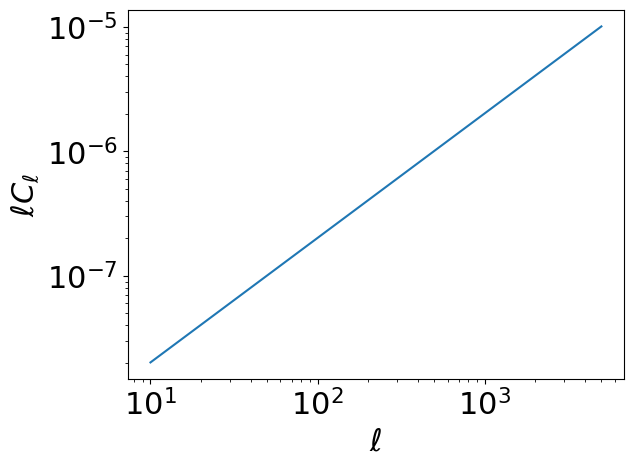

In [22]:
fig, ax = plt.subplots()
ax.loglog(ell,ell*means[0])
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\ell C_\ell$')
#ax.set_ylim(1e-20,1e-3)
#ax.axhline(y=1E-9,ls='--',c='k')
#ax.axvline(x=1E2,ls='--',c='k')

## Compute the covariance at the fiducial cosmology using ```jax-cosmo```

### Define the function

In [23]:
@jax.jit
def compute_gaussian_covariance(params,nzs_source,nzs_lens=nzs_l,ell=ell,f_sky=0.25, zpivot_ia=z0):
    """
    Rerturns the Gaussian covariance for a 3x2pt data vector
    """
## First unpack parameter vector
    cosmo_params, b_l, (A, eta), dz_l, m, dz_s = unpack_params_vec(params)
    #cosmo_params, (A, eta), m, dz_s = unpack_params_vec(params)

    ## Specify cosmology
    cosmo = jc.Cosmology(Omega_m=cosmo_params[0],
                         Omega_c=cosmo_params[0]-cosmo_params[1],
                         Omega_b=cosmo_params[1],
                         Omega_k=PL18_omegak,
                         h=cosmo_params[2],
                         n_s=cosmo_params[3],
                         S8=cosmo_params[4], sigma8=cosmo_params[4]/(cosmo_params[0]/0.3)**0.5,
                         w0=cosmo_params[5], wa = cosmo_params[6],
                         gamma0=cosmo_params[7], gamma1=cosmo_params[8])
    
    ## Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_source, dz_s)]
    ## Define IA model
    a_ia = jc.bias.des_y1_ia_bias(A, eta, zpivot_ia)
    
    ## Build lens nz with redshift systematic bias
    nzs_l_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_lens, dz_l)]
    ## Bias for the lenses
    b = [jc.bias.constant_linear_bias(bi) for bi in b_l] 

    ## Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=a_ia,
                                    multiplicative_bias=m),
             jc.probes.NumberCounts(nzs_l_sys, b)]
    #probes = [jc.probes.WeakLensing(nzs_s_sys,
    #                                ia_bias=a_ia,
    #                                multiplicative_bias=m)]
    
    cl_signal = jc.angular_cl.angular_cl(cosmo, ell, probes)
    cl_noise = jc.angular_cl.noise_cl(ell, probes)
    
    cov = jc.angular_cl.gaussian_cl_covariance(ell, probes, cl_signal, cl_noise, f_sky=f_sky, sparse=False)

    print('cov pre-cut: ',cov.shape)
    cov = cov[matrix_inds_cut]
    print('cov post-cut: ', cov.shape)
    
    return cov

### Call the function to get the covariance and compute its inverse

The inverse of the covariance matrix is usually referred to as the *precision matrix*.

In [24]:
cov_mat = compute_gaussian_covariance(fid_params,nzs_s, f_sky = euc_fsky)
prc_mat = np.linalg.inv(cov_mat)

cov pre-cut:  (10500, 10500)
cov post-cut:  (6300, 6300)


## Compute the Jacobian using jax-cosmo

We wrote a function to compute the mean of the 3x2-point data vector. We can use that to compute the Jacobian using ```jax-cosmo```

Let's redefine the function to compute the mean data vector above, this time flatten the output.

In [25]:
# Defining jax-cosmo jacobian
compute_3x2pt_jac = jax.jit(jax.jacfwd(compute_3x2pt_mean))
#compute_3x2pt_jac = jax.jacfwd(compute_3x2pt_mean)

In [26]:
jacobian = compute_3x2pt_jac(fid_params,nzs_s)
#%timeit compute_3x2pt_jac(fid_params,nzs_s).block_until_ready()

## Compute Fisher matrix

In [27]:
## Take the matrix product
#del(fisher)
fisher = jacobian.T @ prc_mat @ jacobian
print(fisher.shape)

(51, 51)


In [28]:
lens_photoz_priors = (1./(3e-2*(1.+zbin_centers_l))**2)
fisher=fisher.at[cosmo_param_nr+12:cosmo_param_nr+22,cosmo_param_nr+12:cosmo_param_nr+22].add(lens_photoz_priors);
#fisher=fisher.at[cosmo_param_nr+10:cosmo_param_nr+20,cosmo_param_nr+10:cosmo_param_nr+20].add(lens_photoz_priors);

shear_calibration_priors = (1./(1.3e-2)**2)*np.ones((10,))
fisher=fisher.at[cosmo_param_nr+22:cosmo_param_nr+32,cosmo_param_nr+22:cosmo_param_nr+32].add(shear_calibration_priors);
#fisher=fisher.at[cosmo_param_nr+2:cosmo_param_nr+12,cosmo_param_nr+2:cosmo_param_nr+12].add(shear_calibration_priors);

source_photoz_priors = (1./(5e-2*(1.+zbin_centers_l))**2)
fisher=fisher.at[cosmo_param_nr+32:cosmo_param_nr+42,cosmo_param_nr+32:cosmo_param_nr+42].add(source_photoz_priors);
#fisher=fisher.at[cosmo_param_nr+12:cosmo_param_nr+22,cosmo_param_nr+12:cosmo_param_nr+22].add(source_photoz_priors);

In [29]:
#Methods to easily save and load fisher matrices to storage
from numpy import savetxt, loadtxt

def saveFisher(fid_vals, fisher, fname='gammaprime_S8_Euclid_fisher.csv', delimiter=',', **kwargs):
   mat = np.append(fisher, np.reshape(fid_vals, (1, fisher.shape[0])), axis=0)
   savetxt(fname, mat, delimiter=delimiter, **kwargs)


def loadFisher(fname : str, delimiter=',', **kwargs):
   mat = loadtxt(fname, delimiter=delimiter, **kwargs)
   fisher = mat[:mat.shape[1], :mat.shape[1]]
   fid_vals = mat[mat.shape[1], :]
   return fid_vals, fisher

In [30]:
#saveFisher(fid_params, fisher, fname='gammaprime_S8-Omegam_Euclid_3x2_fisher.csv')

Text(0.5, 0.98, 'Euclid 3x2-pt, DES priors on photo-z and shear calibration')

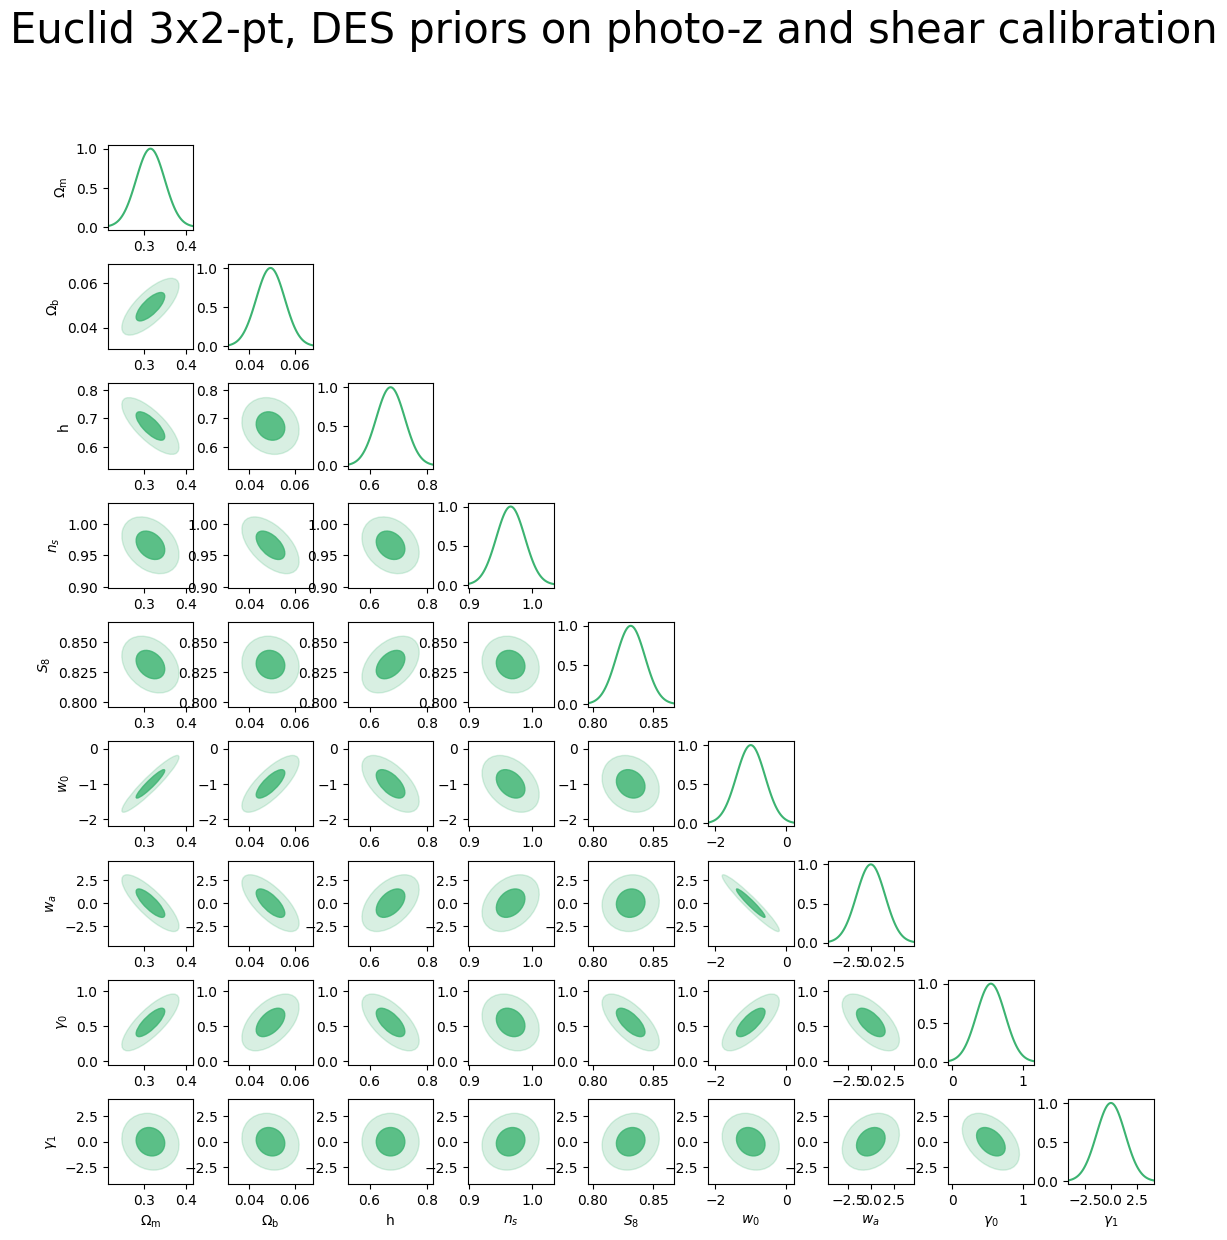

In [31]:
extract_params=9
param_names = (r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', 'h', r'$n_s$', r'$S_8$',
               r'$w_0$', r'$w_a$',
               r'$\gamma_0$',r'$\gamma_1$')
               #r'$b_{l,1}$', r'$b_{l,2}$', r'$b_{l,3}$', r'$b_{l,4}$', r'$b_{l,5}$')

fisher_inv = jax.scipy.linalg.inv(fisher)

fig= plt.figure(figsize=(extract_params*1.5, extract_params*1.5))
plt.rcParams.update({
    "font.size": 10})
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for i in range(extract_params):
    for j in range(extract_params):
        if j<i:
            plt.subplot(extract_params,extract_params,i*extract_params+j+1)
            plot_contours(fisher_inv, fid_params, np.array([j,i]),fill=True,antialiased=True,color='mediumseagreen')
        if j==i:
            plt.subplot(extract_params, extract_params, i*extract_params+j+1)
            plot_Gaussian(fisher_inv, fid_params, i, color='mediumseagreen')
        if i == extract_params - 1:
            plt.xlabel(param_names[j])
        if j == 0:
            plt.ylabel(param_names[i])
fig.suptitle(r'Euclid 3x2-pt, DES priors on photo-z and shear calibration', fontsize=30)